In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import os
import copy
import json
import argparse
import datetime
import collections
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from CustomLoader import CustomLoader
from GCN import GCN
from utils import metric_fn, mse
from models import GRU,MLP
tqdm.pandas()

from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler

import gc

## configuraion

In [7]:
import os
from os import path

class Config:

    root = os.getcwd()
    DATA_PATH = path.join(root, 'data')
    RESULT_PATH = path.join(root, 'output')

cfg = Config()

## matrix construction

In [4]:

# set which columns to read, we replace the author column with the text column
cfg.id_col = "REPORT_ID"
cfg.date_col = "PUBLISH_DATE"
cfg.ticker_col = "SEC_CODE"
cfg.vec_col = "vector"
cfg.t_col = "TITLE"
cfg.a_col = "ABSTRACT"
cfg.read_col_lst = [cfg.id_col, cfg.date_col, cfg.ticker_col, cfg.t_col, cfg.a_col, cfg.vec_col]

# set the matrix construction time point
cfg.matrix_freq = "QE"
cfg.lookback = 2
cfg.matrix_name = f"sac_txt_{cfg.vec_col}_{cfg.matrix_freq}{cfg.lookback}"
cfg.matrix_dir = path.join(cfg.DATA_PATH, f"matrix_{cfg.matrix_name}")

if not os.path.exists(cfg.matrix_dir):
    os.mkdir(cfg.matrix_dir)


# set the time horizon
cfg.start_date, cfg.end_date = pd.to_datetime("20170930"), pd.to_datetime("20231231")
print([cfg.start_date, cfg.end_date])

price_df = pd.read_csv(path.join(cfg.DATA_PATH, "stock_close_post.csv"), index_col=0)
price_df.index = pd.to_datetime(price_df.index.astype("str"))
stock_lst = sorted(price_df.columns)
print(len(stock_lst))

daily_dates = pd.Series(price_df.index, index=price_df.index)
matrix_dates = daily_dates.groupby(pd.Grouper(freq=cfg.matrix_freq)).tail(1) # head(1) #
matrix_dates = matrix_dates.index
daily_dates = daily_dates.index

[Timestamp('2017-09-30 00:00:00'), Timestamp('2023-12-31 00:00:00')]
5346


In [ ]:
# read data
data_df = pd.read_parquet(path.join(cfg.DATA_PATH, f"report.parquet"),
                          columns=cfg.read_col_lst)
data_df = data_df[data_df[cfg.ticker_col].isin(stock_lst)]
print(data_df.shape)

data_df.head(5)

(380406, 6)


,REPORT_ID,PUBLISH_DATE,SEC_CODE,TITLE,ABSTRACT,vector
0,1746261,2019-10-20,002572.SZ,索菲亚（002572）：业绩优于预期，优质成长无忧,美联储重启购债：9月17日，纽约联储开启10年来首次隔夜回购操作，向市场注入短期流动性，并在...,"[-0.0005603107274509966, 0.537570595741272, -0..."
1,1990977,2017-06-01,300144.SZ,宋城演艺(300144)公司公告点评：品牌优势尽显，第二单轻资产业务落地,投资要点：\n\n 事件：公司5月26日收到佛山市南海区樵山建设投资有限公司发来的《中...,"[0.14261654019355774, 0.454537957906723, -0.00..."
2,1991110,2017-06-01,300473.SZ,德尔股份(300473)：新业务静待落地开花，公司向综合型解决方案服务商转型,油耗法规+电动化+智能化，EPS、EHPS加速替代HPS\n\n 电动助力转向系统EP...,"[0.22509707510471344, 0.32062262296676636, -0...."
3,1991174,2017-06-01,600258.SH,首旅酒店(600258)：新一轮酒店发展周期下的成长龙头,核心观点\n\n 并购如家大幅提升业绩，公司跃升酒店行业新龙头，实现高中低端的全面覆盖...,"[0.591457724571228, 0.41629886627197266, -0.60..."
4,1991330,2017-06-01,600516.SH,"方大炭素(600516)：涨价趋势确立,盈利短期持续向好","炭素龙头迎来业绩拐点:近年来由于下游需求市场如钢铁行业景气度下滑,电炉钢占粗钢比例逐年下降,...","[0.26284947991371155, 0.30878254771232605, -0...."


In [ ]:
# construct matrix
cfg.loop_dates_all = matrix_dates
cfg.loop_dates_range = list(filter(lambda x: (x >= cfg.start_date) & (x <= cfg.end_date), cfg.loop_dates_all))
print(cfg.loop_dates_range)
for curr_date in tqdm(cfg.loop_dates_range):
    curr_date_start = cfg.loop_dates_all[np.where(cfg.loop_dates_all == curr_date)[0][0] - cfg.lookback]
    curr_date_end = curr_date
    tmp_data = data_df[(data_df[cfg.date_col] >= curr_date_start) & (data_df[cfg.date_col] < curr_date_end)]
    stock_vec = tmp_data.groupby(cfg.ticker_col)[cfg.vec_col].apply(lambda x: np.array(x.values.tolist()).mean(axis=0))
    stock_mtx = np.vstack(stock_vec.values)
    sim_mtx = cosine_similarity(stock_mtx)
    np.fill_diagonal(sim_mtx, np.nan)
    matrix = pd.DataFrame(sim_mtx, index=stock_vec.index, columns=stock_vec.index)
    matrix_all = pd.DataFrame(np.nan, index=stock_lst, columns=stock_lst)
    matrix_all.update(matrix)
    matrix_all.to_parquet(path.join(cfg.matrix_dir, f"{curr_date.strftime('%Y%m%d')}.parquet"))

# here are the matrices we contruct
print(os.listdir(cfg.matrix_dir))
matrix_all

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-03-30 00:00:00'), Timestamp('2018-06-29 00:00:00'), Timestamp('2018-09-28 00:00:00'), Timestamp('2018-12-28 00:00:00'), Timestamp('2019-03-29 00:00:00'), Timestamp('2019-06-28 00:00:00'), Timestamp('2019-09-30 00:00:00'), Timestamp('2019-12-31 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-03-31 00:00:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-09-30 00:00:00'), Timestamp('2022-12-30 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-09-28 00:00:00'), Timestamp('2023-12-29 00:00:00')]


100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

['20171229.parquet', '20180330.parquet', '20180629.parquet', '20180928.parquet', '20181228.parquet', '20190329.parquet', '20190628.parquet', '20190930.parquet', '20191231.parquet', '20200331.parquet', '20200630.parquet', '20200930.parquet', '20201231.parquet', '20210331.parquet', '20210630.parquet', '20210930.parquet', '20211231.parquet', '20220331.parquet', '20220630.parquet', '20220930.parquet', '20221230.parquet', '20230331.parquet', '20230630.parquet', '20230928.parquet', '20231229.parquet']


,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,688788.SH,688789.SH,688793.SH,688798.SH,688799.SH,688800.SH,688819.SH,688981.SH,689009.SH,990018.SH
000001.SZ,NaN,0.961423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.923832,0.923358,0.917624,NaN,0.911927,0.908412,0.933672,0.951941,NaN
000002.SZ,0.961423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.957219,0.950215,0.952749,NaN,0.950234,0.947622,0.953304,0.971583,NaN
000003.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688800.SH,0.911927,0.950234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.971304,0.949801,0.983084,NaN,NaN,0.970840,0.952041,0.963750,NaN
688819.SH,0.908412,0.947622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.956679,0.935497,0.960059,NaN,0.970840,NaN,0.933885,0.951109,NaN
688981.SH,0.933672,0.953304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.949275,0.937398,0.963898,NaN,0.952041,0.933885,NaN,0.961693,NaN
689009.SH,0.951941,0.971583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.965322,0.975711,0.969799,NaN,0.963750,0.951109,0.961693,NaN,NaN


## Stock Prediction Model

In [3]:
def main(args):
    seed = np.random.randint(1000000)
    np.random.seed(seed)
    torch.manual_seed(seed)
    suffix = "%s_dh%s_dn%s_drop%s_lr%s_bs%s_seed%s%s"%(
        args.model_name, args.hidden_size, args.num_layers, args.dropout,
        args.lr, args.batch_size, args.seed, args.annot
    )  # 只有%s是占位符，其他的都是字符串

    output_path = args.outdir
    if not output_path:
        output_path = './output/' + suffix
    if not os.path.exists(output_path):
        os.makedirs(output_path)


    global global_log_file  
    global_log_file = output_path + '/' + '_run.log'

    train_dataset = Dataset('20180101', '20221231', args.model_name, args.matrix_dir,'train')
    valid_dataset = Dataset('20230101', '20230630', args.model_name, args.matrix_dir,'valid')
    test_dataset = Dataset('20230701', '20240315', args.model_name, args.matrix_dir,'test')

    train_dataset.all_stock('20180101','20221231')  # 维护一个全市场股票列表
    valid_dataset.all_stock('20180101','20221231')
    test_dataset.all_stock('20180101','20221231')
    
    # 创建 DataLoader
    train_loader = CustomLoader(train_dataset, batch_size=1, shuffle=True, flag = 'train') # 不同天的股票数不同，如果想要batch_size>1，就要自己构造一个
    valid_loader = CustomLoader(valid_dataset, batch_size=1, shuffle=False, flag = 'valid')
    test_loader = CustomLoader(test_dataset, batch_size=1, shuffle=False, flag = 'test')

    writer = SummaryWriter(log_dir=output_path)  # Tesnorboard日志存储

    if args.model_name == 'SFM':
        model = get_model(args.model_name)(d_feat = args.d_feat, output_dim = 32, freq_dim = 25, hidden_size = args.hidden_size, dropout_W = 0.5, dropout_U = 0.5, device = device)
    elif args.model_name == 'ALSTM':
        model = get_model(args.model_name)(args.d_feat, args.hidden_size, args.num_layers, args.dropout, 'LSTM')
    elif args.model_name == 'Transformer':
        model = get_model(args.model_name)(args.d_feat, args.hidden_size, args.num_layers, dropout=0.5)
    elif args.model_name == 'HIST':
        model = get_model(args.model_name)(d_feat = args.d_feat, num_layers = args.num_layers, K = args.K)
    elif args.model_name == 'GAT':
        model = get_model(args.model_name)(num_heads_per_layer = [8]*args.num_layers, num_features_per_layer = [args.d_feat] + [args.hidden_size]*args.num_layers, num_of_layers = args.num_layers, layer_type = LayerType.IMP3)
    elif args.model_name == 'MLP':
        model = MLP(args.d_feat)
    else:
        model = get_model(args.model_name)(d_feat = args.d_feat, num_layers = args.num_layers)
    
    model.to(args.device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    best_ic = -np.inf
    best_epoch = 0
    stop_round = 0
    best_param = copy.deepcopy(model.state_dict())
    # params_list = collections.deque(maxlen=args.smooth_steps)
    metrics = []  # Collect metrics for CSV

    epoch = 0
    train_loss, train_score, train_precision, train_recall, train_ic, train_rank_ic = test_epoch(epoch, model, train_loader, writer, args, prefix='Train')
    val_loss, val_score, val_precision, val_recall, val_ic, val_rank_ic = test_epoch(epoch, model, valid_loader, writer, args, prefix='Valid')
    test_loss, test_score, test_precision, test_recall, test_ic, test_rank_ic = test_epoch(epoch, model, test_loader, writer, args, prefix='Test')
    epoch_metrics = [train_loss, train_score, train_ic, train_rank_ic, val_loss, val_score,val_ic, val_rank_ic,test_loss, test_score, test_ic, test_rank_ic]
    metrics.append(epoch_metrics)
    
    for epoch in range(args.n_epochs):
        train_epoch(epoch, model, optimizer, train_loader, writer, args)  # 训练
        torch.save(model, output_path + '/model_last_epoch.pth')

        params_ckpt = copy.deepcopy(model.state_dict())

        train_loss, train_score, train_precision, train_recall, train_ic, train_rank_ic = test_epoch(epoch, model, train_loader, writer, args, prefix='Train')
        val_loss, val_score, val_precision, val_recall, val_ic, val_rank_ic = test_epoch(epoch, model, valid_loader, writer, args, prefix='Valid')
        test_loss, test_score, test_precision, test_recall, test_ic, test_rank_ic = test_epoch(epoch, model, test_loader, writer, args, prefix='Test')

        model.load_state_dict(params_ckpt)

        epoch_metrics = [train_loss, train_score, train_ic, train_rank_ic, val_loss, val_score,val_ic, val_rank_ic,test_loss, test_score, test_ic, test_rank_ic]
        metrics.append(epoch_metrics)

        if val_rank_ic > best_ic:
            best_ic = val_rank_ic
            stop_round = 0
            best_epoch = epoch
            # best_param = copy.deepcopy(avg_params)  # 存储的最优模型也存的是平均参数
            torch.save(model, output_path + '/model_best.pth')
        else:
            stop_round += 1
            if stop_round >= args.early_stop:
                print('early stop')
                break


    metrics = pd.DataFrame(metrics, columns=['train_loss', 'train_score',  
                                                'train_ic', 'train_rank_ic', 'valid_loss', 'valid_score',  'valid_ic', 'valid_rank_ic', 'test_loss', 'test_score', 
                                                'test_ic', 'test_rank_ic'])
    metrics.to_csv(output_path+'/metrics.csv')

    print('inference...')
    model = torch.load(output_path + '/model_best.pth')
    for name in ['train', 'valid', 'test']:
        pred= inference(model, eval(name+'_loader'), cfg)
        pred.to_pickle(output_path+'/pred.pkl.'+name)
        
    print('best score:', best_ic, '@', best_epoch)

    print('finished.')


In [4]:
# parameter
# model
cfg.d_feat = 61
cfg.hidden_size = 128
cfg.num_layers = 2
cfg.dropout = 0.0
cfg.K = 1

# training
cfg.n_epochs = 30
cfg.lr = 2e-4
cfg.early_stop = 20
cfg.smooth_steps = 5
cfg.metric = 'IC'
cfg.loss = 'mse'
cfg.batch_size = -1 # how many stocks to train at the same time, -1 means all(in a day )

# data
cfg.pin_memory = True
cfg.least_samples_num = 1137.0
cfg.label = ''  # specify other labels
cfg.matrix_dir='./data/matrix_sac_txt_vector_QE2'

# other
cfg.seed = 0
cfg.annot = ''
cfg.config = ''
cfg.device = 'cuda:0'

cfg.overwrite = False

### MLP

100%|██████████| 207/207 [00:01<00:00, 112.79it/s]
/root/autodl-tmp/project/datasetMLP.py:186: RuntimeWarning: invalid value encountered in divide
  Data = (Data - np.mean(Data, axis=0)) / stds


early stop
inference...
best score: 0.09513074593237203 @ 12
finished.


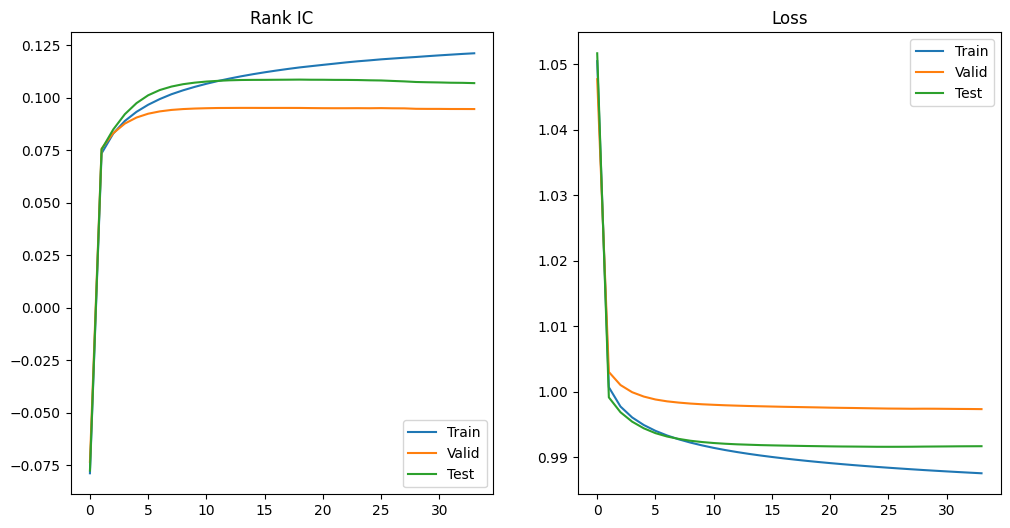

In [5]:
from datasetMLP import Dataset
from learnMLP import get_model, test_epoch, train_epoch, parse_args, inference
from utils import plot_result
# dimension: (batch_size, frature_dim) -> (batch_size, 1)
cfg.model_name='MLP'
cfg.n_epochs=30
cfg.outdir='./output/MLP'
main(cfg)
plot_result(os.path.join(cfg.outdir, 'metrics.csv'))

### GRU

100%|██████████| 207/207 [00:02<00:00, 101.72it/s]


inference...
best score: 0.09613353356268273 @ 30
finished.


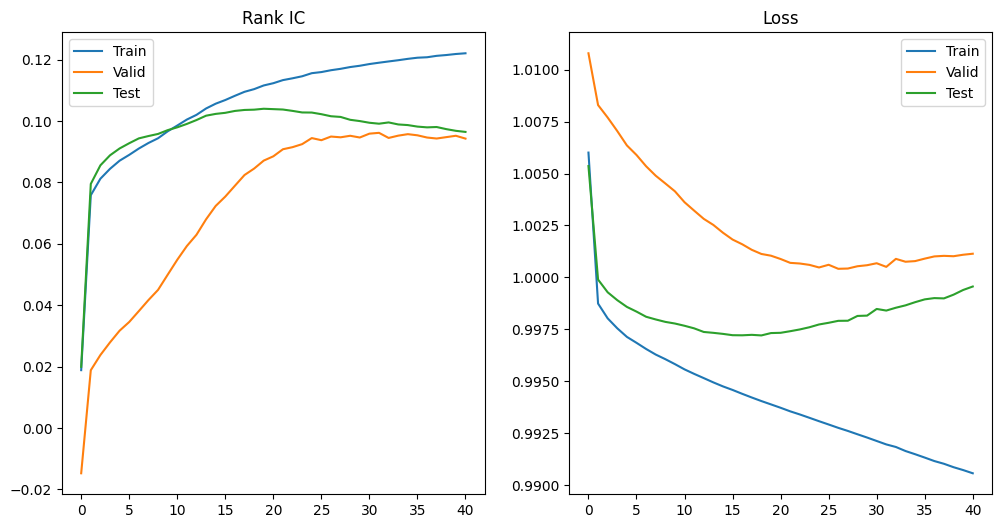

In [22]:
from dataset import Dataset
from learn import get_model, test_epoch, train_epoch, parse_args, inference
from utils import plot_result
# dimension: (batch_size, seq_len, feature_dim) -> (batch_size, 1)
cfg.model_name='GRU'
cfg.n_epochs=30
cfg.outdir='./output/GRU'
main(cfg)
plot_result(os.path.join(cfg.outdir, 'metrics.csv'))

### GCN

100%|██████████| 207/207 [00:02<00:00, 100.39it/s]


early stop
inference...
best score: 0.13516878911647512 @ 0
finished.


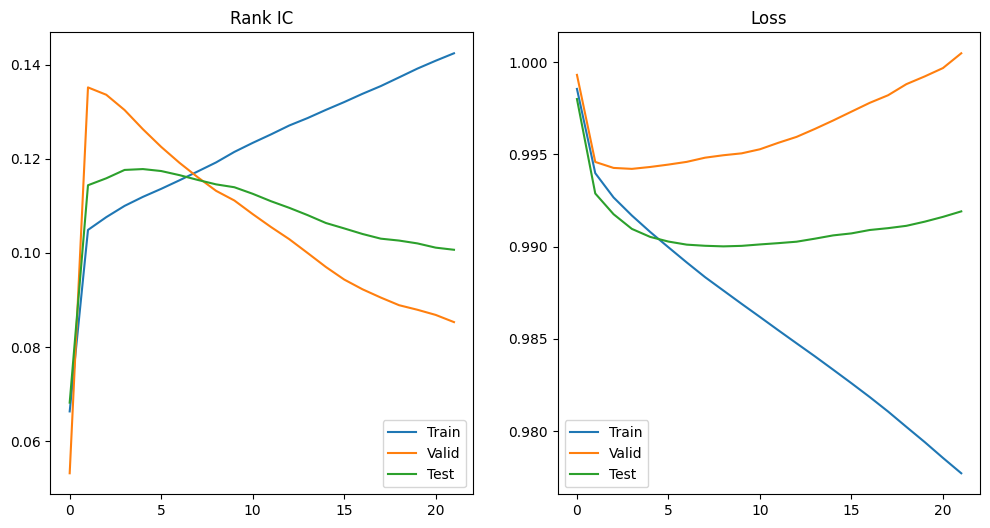

In [7]:
from dataset import Dataset
from learn import get_model, test_epoch, train_epoch, parse_args, inference
from utils import plot_result
# dimension: (batch_size, seq_len, feature_dim) & (batch_size, batch_size) -> (batch_size, 1)
# cfg.model_name='GCN'
# cfg.n_epochs=40
# cfg.outdir='/root/myGNN/output1/matrix_sac'
# cfg.matrix_dir='/root/autodl-tmp/data/matrix_sac'
# main(cfg)
# plot_result(os.path.join(cfg.outdir, 'metrics.csv'))


cfg.model_name='GCN'
cfg.n_epochs=30
cfg.outdir='./output/GCN'
cfg.matrix_dir='./data/matrix_sac_txt_vector_QE2'
main(cfg)
plot_result(os.path.join(cfg.outdir, 'metrics.csv'))

## result

### back test

MLP all 2023-07-01 00:00:00 2023-12-31 00:00:00
trading dates:  122


122it [00:07, 15.72it/s]


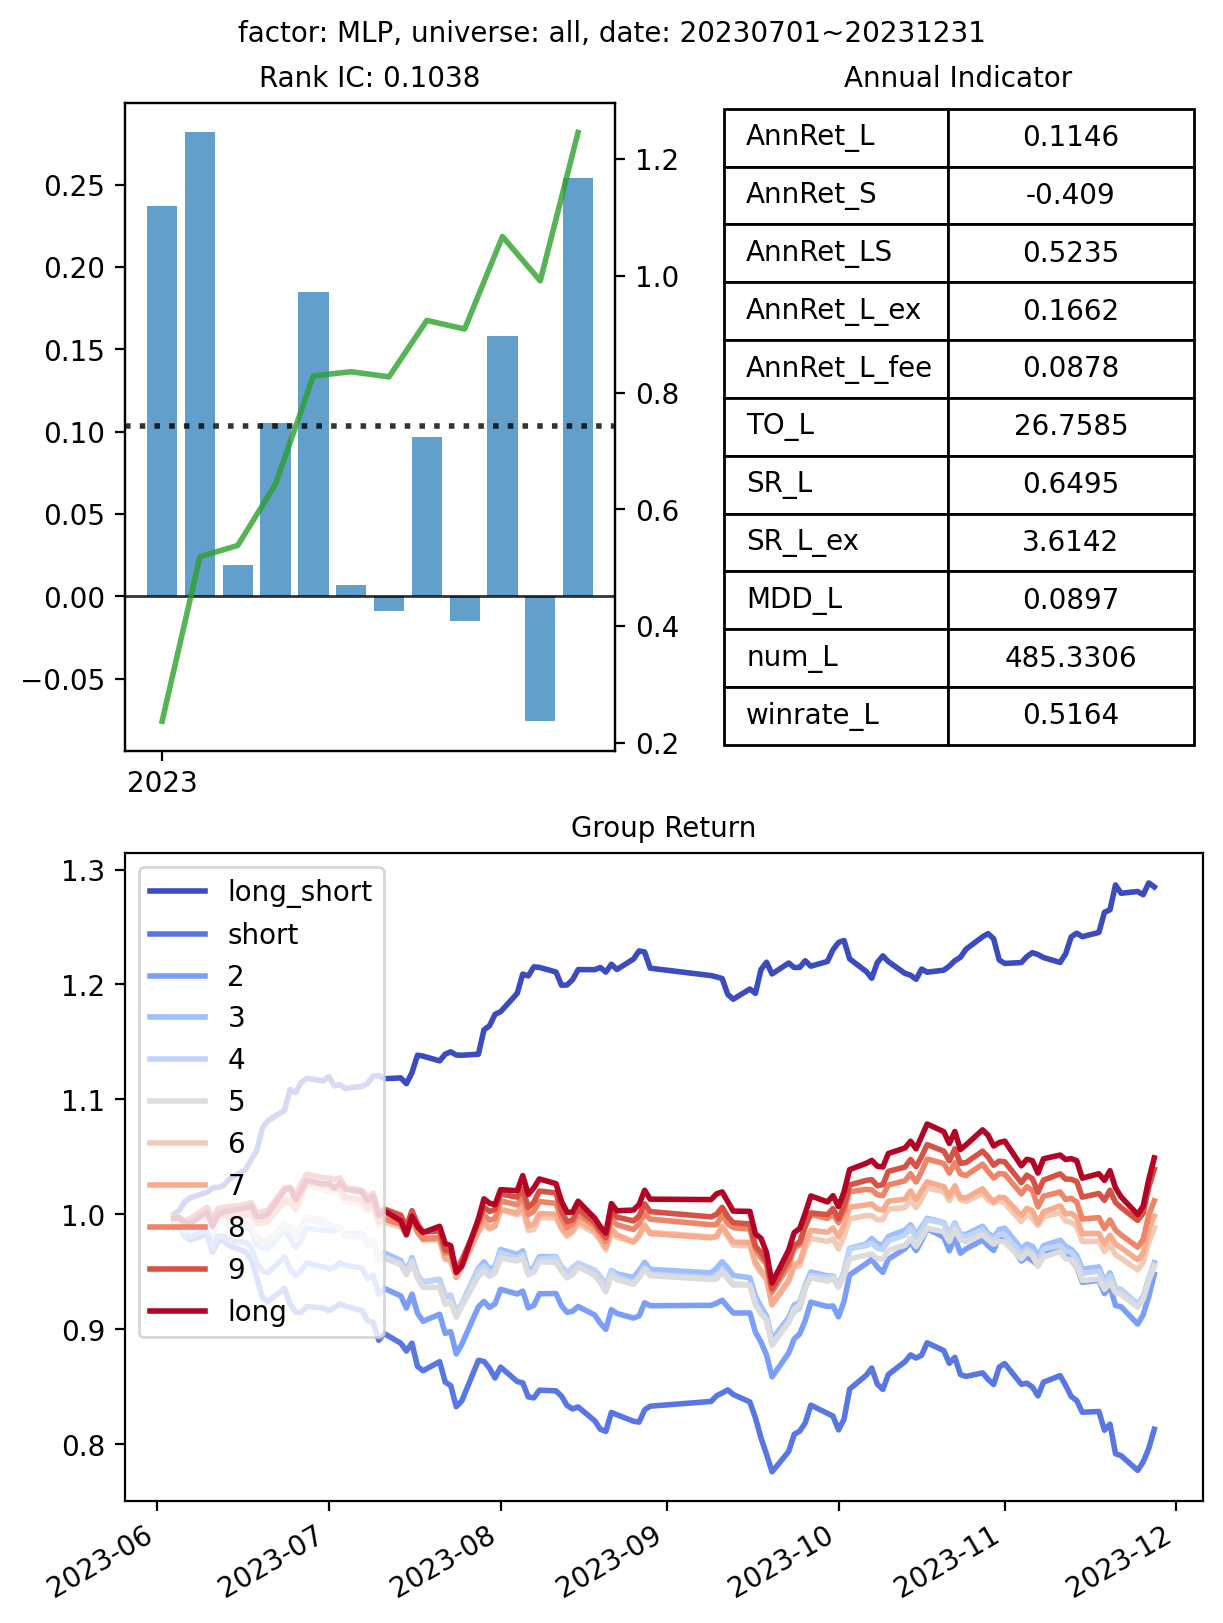

In [4]:

from backtest import bt_plot

cfg.factor_path = "./output/MLP/pred.pkl.test"
cfg.factor_name = "MLP"
cfg.start_date, cfg.end_date = pd.to_datetime("20230701"), pd.to_datetime("20231231")
cfg.fontsize = 10

bt_plot(cfg.factor_path, cfg.factor_name, cfg.start_date, cfg.end_date, cfg.fontsize)


GRU all 2023-07-01 00:00:00 2023-12-31 00:00:00
trading dates:  122


122it [00:07, 15.88it/s]


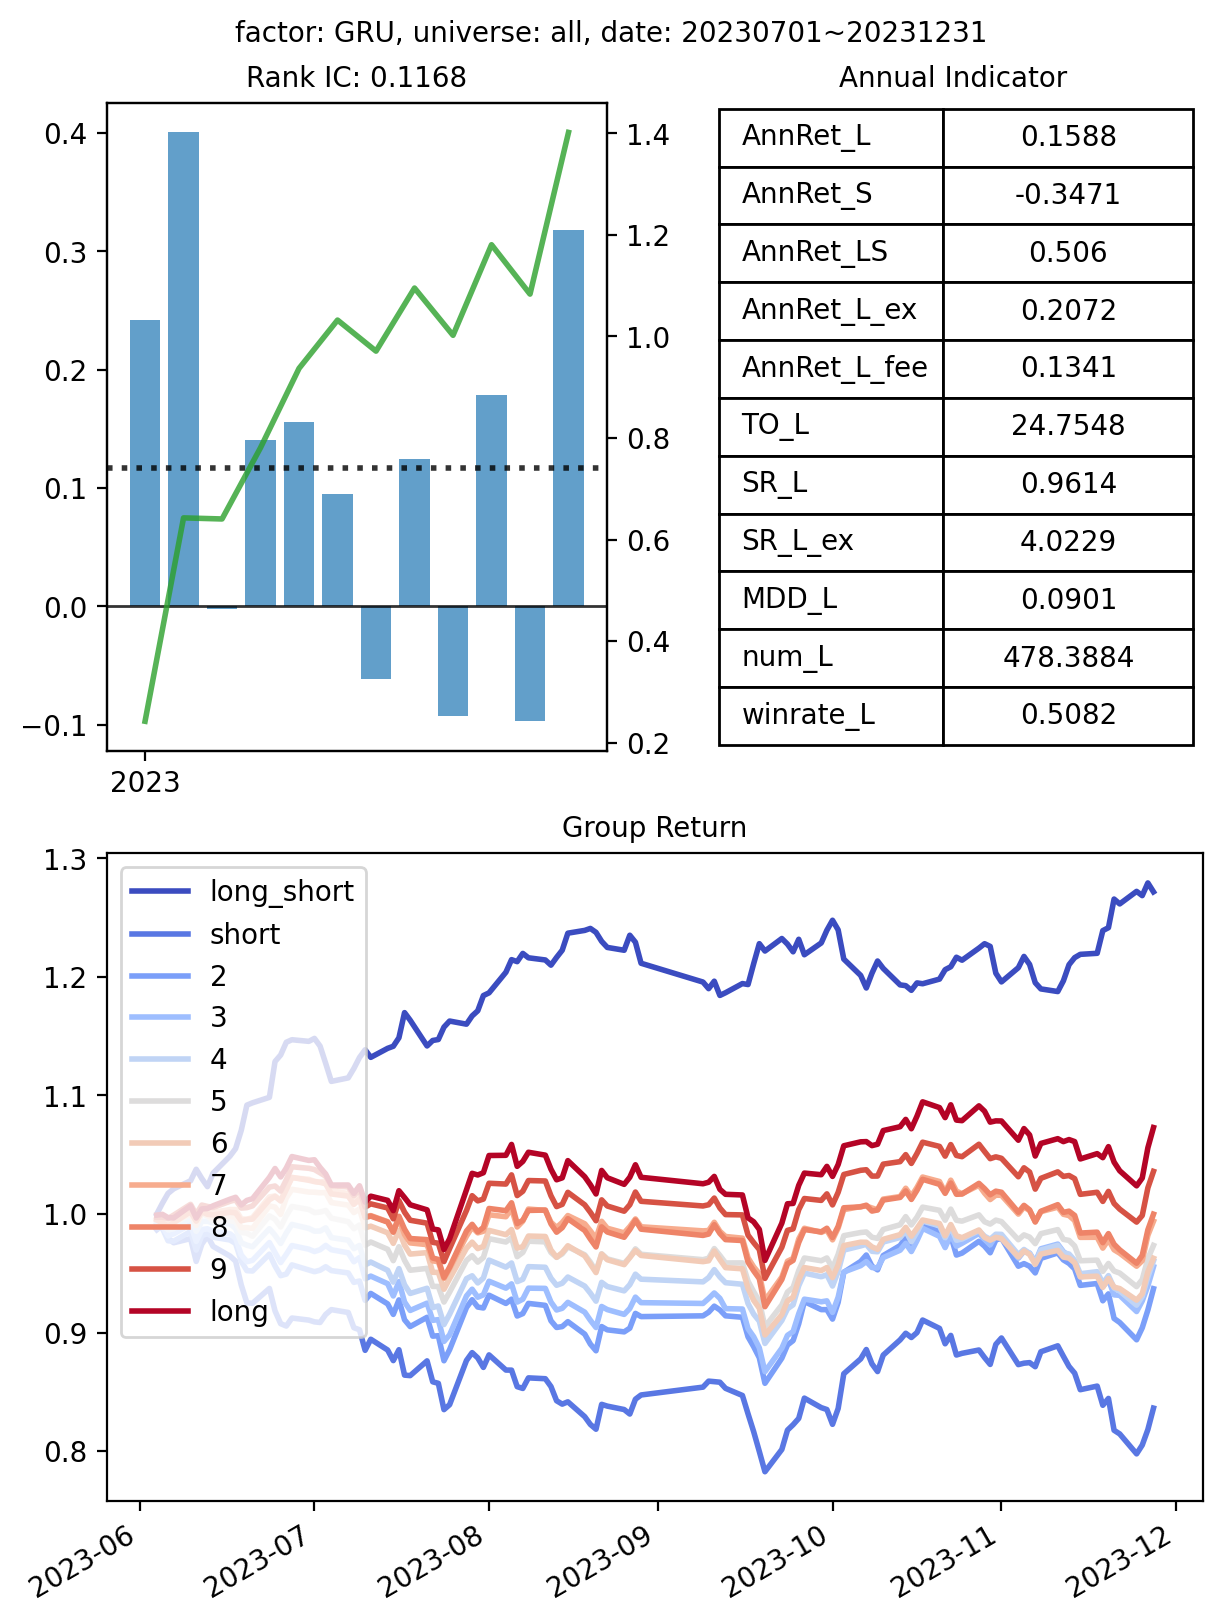

In [9]:

cfg.factor_path = "./output/GRU/pred.pkl.test"
cfg.factor_name = "GRU"
cfg.start_date, cfg.end_date = pd.to_datetime("20230701"), pd.to_datetime("20231231")
cfg.fontsize = 10

bt_plot(cfg.factor_path, cfg.factor_name, cfg.start_date, cfg.end_date, cfg.fontsize)


GCN all 2023-07-01 00:00:00 2023-12-31 00:00:00
trading dates:  122


122it [00:07, 16.18it/s]


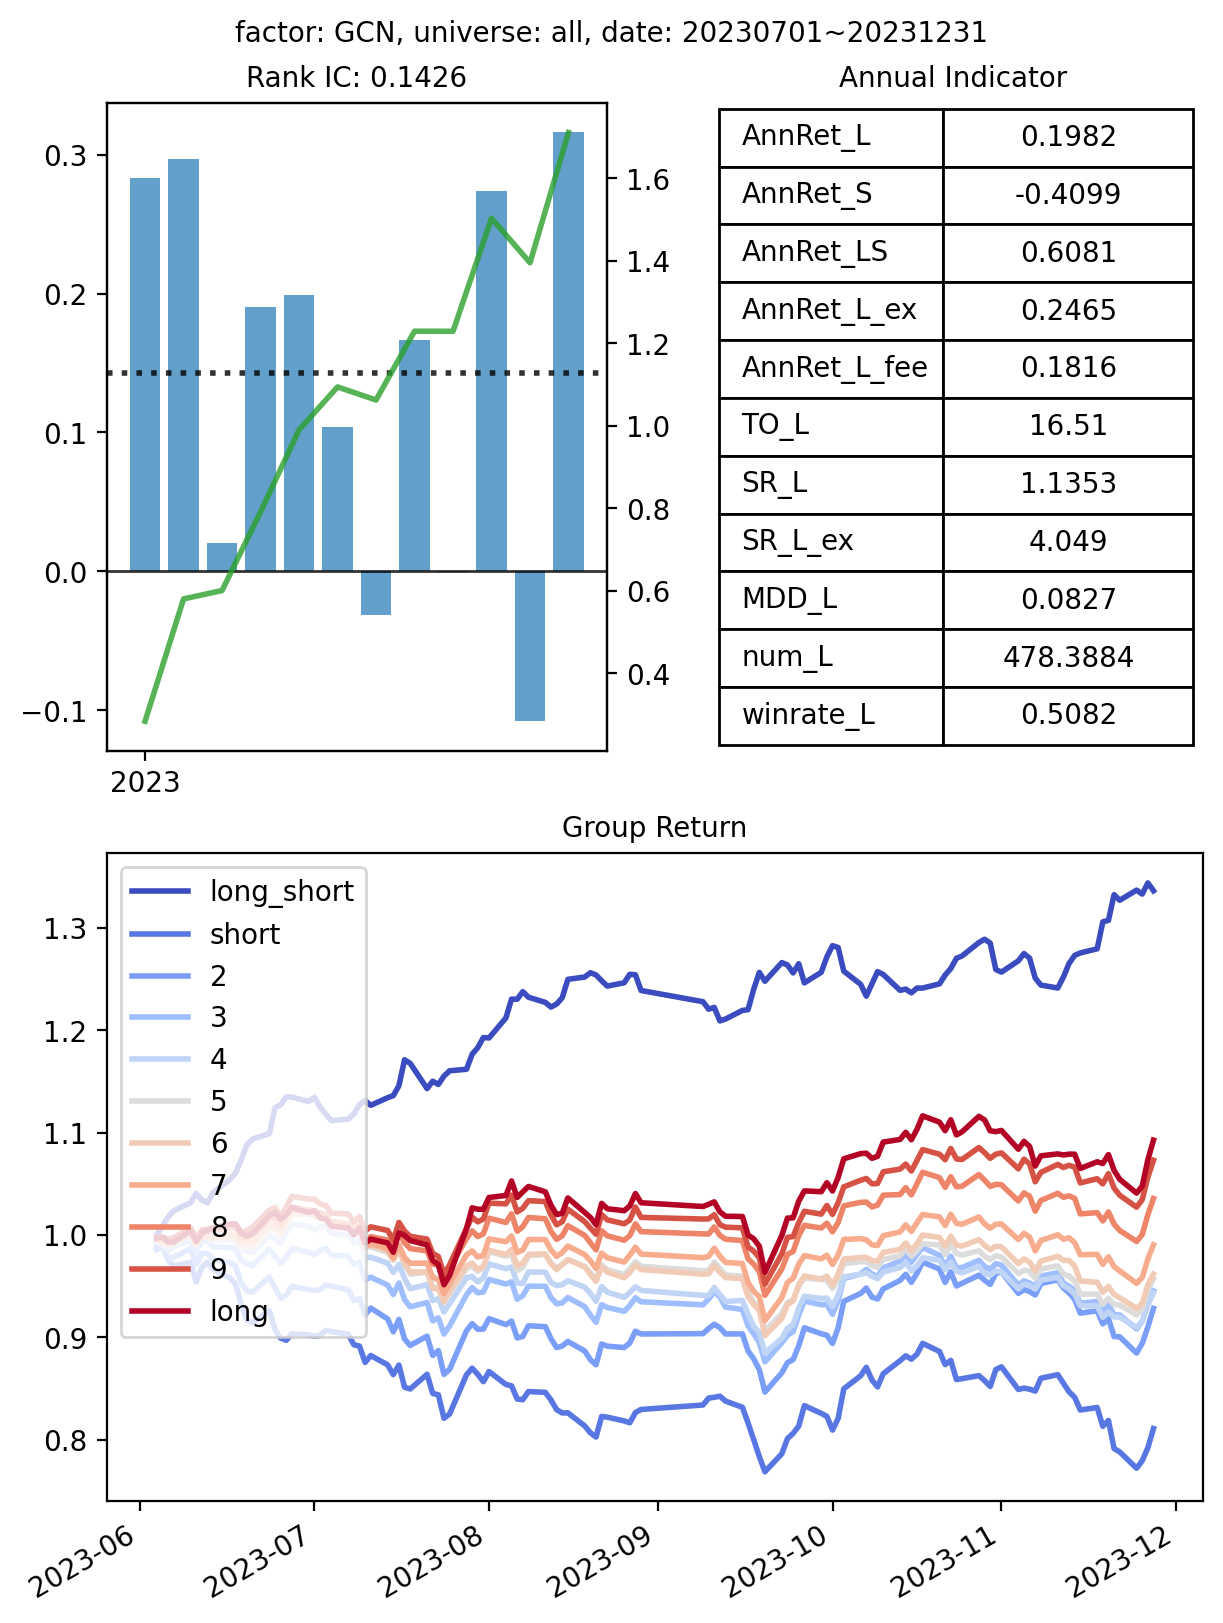

In [13]:

cfg.factor_path = "./output/GCN/pred.pkl.test"
cfg.factor_name = "GCN"
cfg.start_date, cfg.end_date = pd.to_datetime("20230701"), pd.to_datetime("20231231")
cfg.fontsize = 10

bt_plot(cfg.factor_path, cfg.factor_name, cfg.start_date, cfg.end_date, cfg.fontsize)


### confusion matrix

In [8]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [9]:

# classify the predicted acore between 0 and 30 percentile to -1, between 30 and 70 percentile to 0, between 70 and 100 percentile to 1

def classify(x, q_upper, q_lower):
    if x <= q_upper:
        return -1
    elif x >= q_lower:
        return 1
    else:
        return 0
    
def assign_labels(group):
    upper = 0.4
    lower = 0.6
    q_upper = group['score'].quantile(upper)
    q_lower = group['score'].quantile(lower)
    group['pred_group'] = group['score'].apply(classify, args=(q_upper, q_lower))

    q_upper = group['label'].quantile(upper)
    q_lower = group['label'].quantile(lower)
    group['label_group'] = group['label'].apply(classify, args=(q_upper, q_lower))

    return group

def cm_plot(cm, fontsize):
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={"fontsize":cfg.fontsize})
    ax.set_xticklabels(classes, fontsize=cfg.fontsize)
    ax.set_yticklabels(classes, fontsize=cfg.fontsize)
    plt.xlabel('Predicted', fontsize=cfg.fontsize)
    plt.ylabel('Actual', fontsize=cfg.fontsize)

    plt.show()


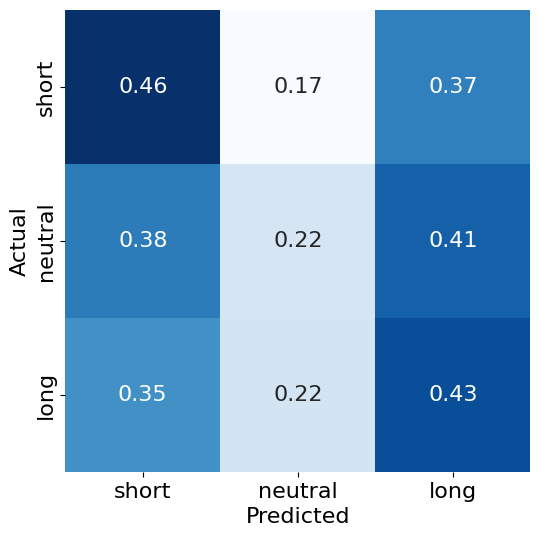

In [10]:

df = pd.read_pickle("./output/MLP/pred.pkl.test")
idx = pd.IndexSlice
df = df.loc[idx[df.index.get_level_values(0) < '20231231', :], :]
df_grouped = df.groupby(level=0).apply(assign_labels)
df_grouped['label_group'].value_counts()


# 定义三分类的类别标签
classes = ['short', 'neutral', 'long']

y_true = df_grouped['pred_group'].values
y_pred = df_grouped['label_group'].values

cm = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=classes, columns=classes)

cfg.fontsize =16

cm_plot(cm, cfg.fontsize)



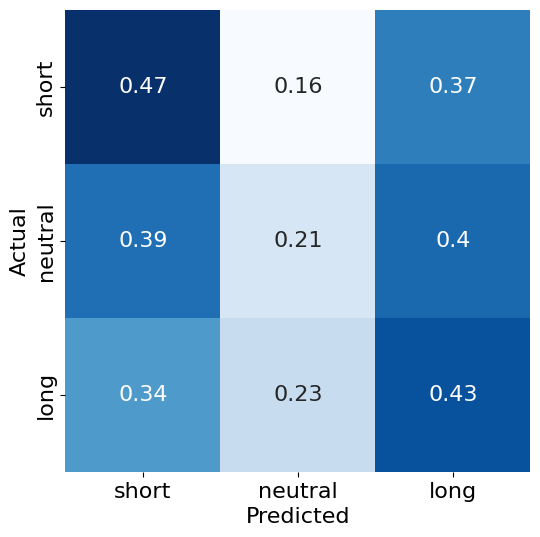

In [11]:

df = pd.read_pickle("./output/GRU/pred.pkl.test")
idx = pd.IndexSlice
df = df.loc[idx[df.index.get_level_values(0) < '20231231', :], :]
df_grouped = df.groupby(level=0).apply(assign_labels)
df_grouped['label_group'].value_counts()


# 定义三分类的类别标签
classes = ['short', 'neutral', 'long']

y_true = df_grouped['pred_group'].values
y_pred = df_grouped['label_group'].values

cm = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=classes, columns=classes)

cm_plot(cm, cfg.fontsize)


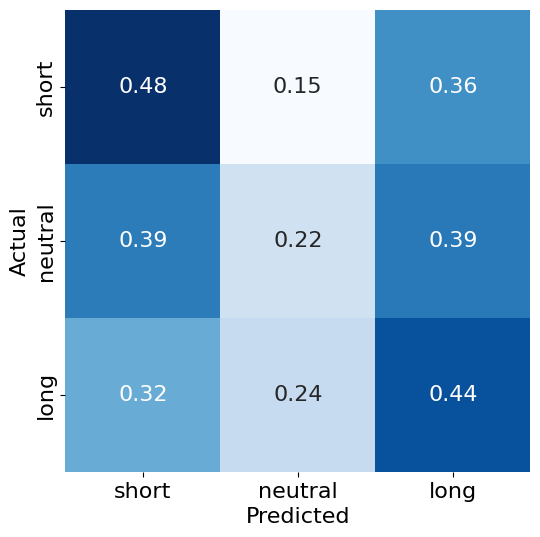

In [12]:

df = pd.read_pickle("./output/GCN/pred.pkl.test")
idx = pd.IndexSlice
df = df.loc[idx[df.index.get_level_values(0) < '20231231', :], :]
df_grouped = df.groupby(level=0).apply(assign_labels)
df_grouped['label_group'].value_counts()


# 定义三分类的类别标签
classes = ['short', 'neutral', 'long']

y_true = df_grouped['pred_group'].values
y_pred = df_grouped['label_group'].values

cm = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=classes, columns=classes)

cm_plot(cm, cfg.fontsize)


**GCN.py**: Graph Convolutional Model

    This module builds a graph convolutional model which can be accessed by instantiating the GCN class. It allows users to apply graph-based neural network architectures to various types of graph-structured data.

**models.py**: Time Series and Cross-Sectional Models

    This file defines two models: a GRU for time series modeling and an MLP (Multilayer Perceptron) for cross-sectional modeling. These models can be utilized by creating instances of GRU and MLP classes, respectively, for sequence data processing and static pattern recognition.

**utils.py**: Optimization and Plotting Functions

    The Optim class is constructed to facilitate the optimization steps during the training process. Additionally, the module defines a plot_result function for visualizing results and includes several functions like mse (Mean Squared Error) and ic (Information Coefficient) to compute various metrics.

**dataset.py**: Data Loading and Pre-processing for Time Series Models

    This script handles the loading of factor data, list of trading days, stock closing prices, market capitalizations, and adjacency matrices. It calculates returns and performs data preprocessing, preparing the dataset specifically for time series models.

**Customloader.py**: Batch Data Iterator

    Constructs an iterator that returns a batch of data (one day at a time), facilitating the training process for models that require sequential input.

**datasetMLP.py**: Data Loading and Pre-processing for Cross-Sectional Models

    Similar to dataset.py, this file loads factor data, lists of trading days, and stock closing prices. It calculates returns and conducts data preprocessing, tailored for cross-sectional models which analyze data across different entities without regard to the sequential order.